<a href="https://colab.research.google.com/github/CarlosRomero55/Remote-Sensing-Satelite-image/blob/main/maloclussion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.4 MB/s eta 0:00:00


Train Dataset Classes Distribution: [416 416]
Test Dataset Classes Distribution: [28 45]
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 428ms/step - accuracy: 0.6698 - loss: 4.0053 - val_accuracy: 0.3836 - val_loss: 2.3511 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7337 - loss: 1.3704 - val_accuracy: 0.3836 - val_loss: 1.2919 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.7356 - loss: 0.9002 - val_accuracy: 0.3836 - val_loss: 1.2875 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.7472 - loss: 0.8135 - val_accuracy: 0.3836 - val_loss: 1.6145 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.7029 - loss: 0.8177 - val_accuracy: 0.3836 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7550 - loss: 0.7210 - val_accuracy

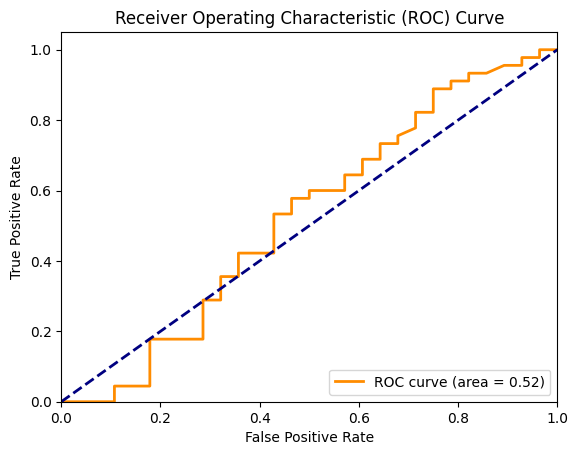

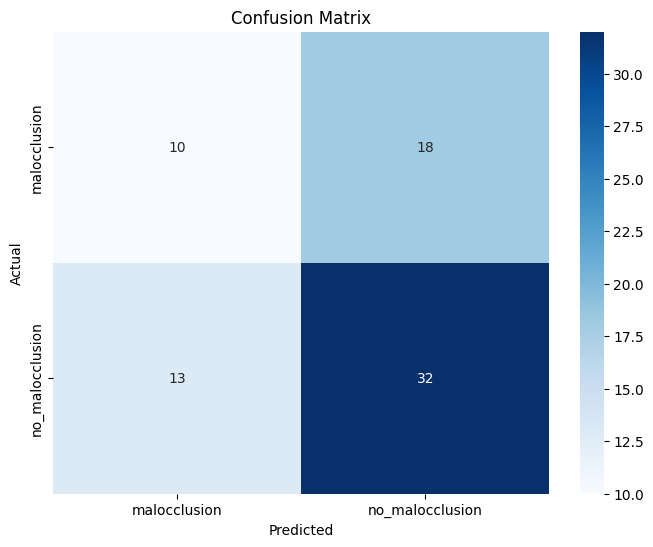

                 precision    recall  f1-score   support

   malocclusion       0.43      0.36      0.39        28
no_malocclusion       0.64      0.71      0.67        45

       accuracy                           0.58        73
      macro avg       0.54      0.53      0.53        73
   weighted avg       0.56      0.58      0.57        73



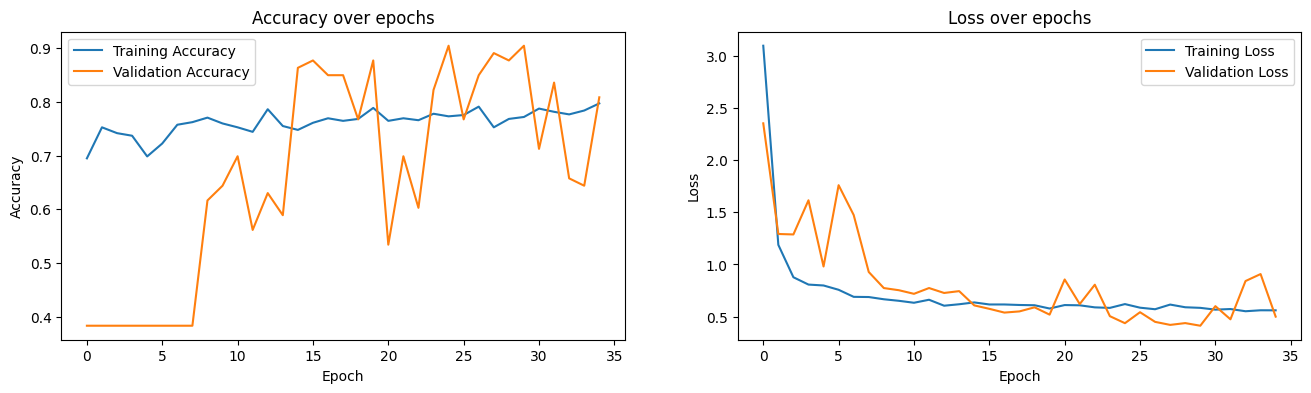

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


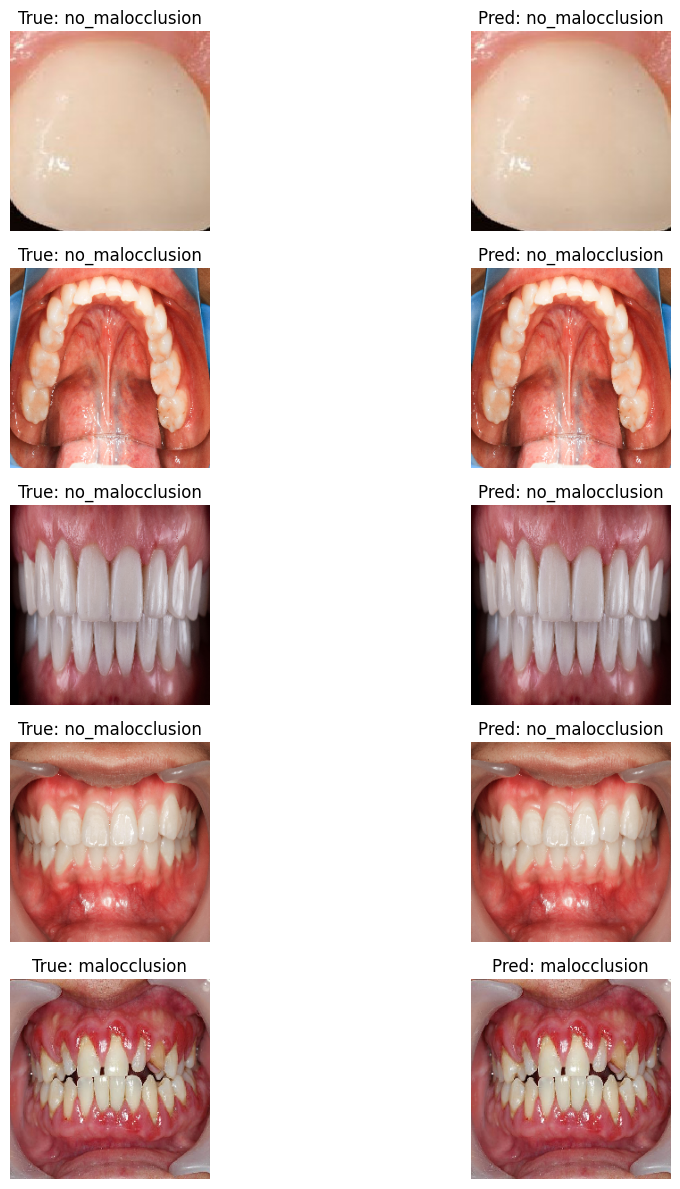

In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score
from PIL import Image, UnidentifiedImageError
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Rutas de los directorios de entrenamiento y prueba
train_dir = '/content/drive/MyDrive/Dataset/train'
test_dir = '/content/drive/MyDrive/Dataset/validation'

# Función para cargar imágenes y sus etiquetas
def load_images_and_labels(directory, target_size=(224, 224)):
    images = []
    labels = []
    class_names = ['malocclusion', 'no_malocclusion']
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img = load_img(os.path.join(class_dir, file), target_size=target_size)
                    img = img_to_array(img)
                    images.append(img)
                    labels.append(label)
                except UnidentifiedImageError:
                    continue
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas de entrenamiento
train_images, train_labels = load_images_and_labels(train_dir)
test_images, test_labels = load_images_and_labels(test_dir)

# Normalizar imágenes
train_images = train_images / 255.0
test_images = test_images / 255.0

# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE()
train_images_resampled, train_labels_resampled = smote.fit_resample(train_images.reshape(train_images.shape[0], -1), train_labels)
train_images_resampled = train_images_resampled.reshape(train_images_resampled.shape[0], 224, 224, 3)

# Crear generadores de datos con tf.data.Dataset
def create_dataset(images, labels, batch_size=32, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if augment:
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_up_down(x), y))
        dataset = dataset.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))
        dataset = dataset.map(lambda x, y: (tf.image.random_contrast(x, 0.8, 1.2), y))
        dataset = dataset.map(lambda x, y: (tf.image.random_hue(x, 0.1), y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_images_resampled, train_labels_resampled, augment=True)
test_dataset = create_dataset(test_images, test_labels)

# Verifica el contenido de los datasets
train_class_distribution = np.bincount(train_labels_resampled)
test_class_distribution = np.bincount(test_labels)
print("Train Dataset Classes Distribution:", train_class_distribution)
print("Test Dataset Classes Distribution:", test_class_distribution)

# Modelo con ResNet50 y capas adicionales
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Congelar las capas base
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configurar callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, save_weights_only=False)

# Entrenamiento del modelo
try:
    history = model.fit(
        train_dataset,
        epochs=50,
        validation_data=test_dataset,
        callbacks=[early_stopping, reduce_lr, model_checkpoint]
    )
except Exception as e:
    print("Error during training:", e)
    history = None

# Guardar el modelo entrenado en formato .keras
model.save('final_model.keras')

# Cargar el modelo entrenado en formato .keras
model = tf.keras.models.load_model('final_model.keras')

# Verifica si el entrenamiento se completó correctamente
if history:
    # Evaluación del modelo
    test_loss, test_acc = model.evaluate(test_dataset)
    print(f"Test accuracy: {test_acc:.2f}")

    predictions = model.predict(test_dataset)
    y_pred = np.round(predictions)

    # Métricas adicionales
    f1 = f1_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)

    print(f"F1-Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    # ROC y AUC
    fpr, tpr, _ = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Matriz de confusión y reporte de clasificación
    conf_matrix = confusion_matrix(test_labels, y_pred)
    class_names = ['malocclusion', 'no_malocclusion']

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report = classification_report(test_labels, y_pred, target_names=class_names)
    print(class_report)

    # Curvas de aprendizaje
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.show()

    # Mostrar algunas imágenes de prueba con predicciones
    num_images = 5
    indices = np.random.choice(len(test_images), num_images, replace=False)
    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(indices):
        img = test_images[idx]
        true_label = test_labels[idx]
        pred_label = model.predict(np.expand_dims(img, axis=0))
        pred_label = (pred_label > 0.5).astype(int)[0][0]
        plt.subplot(num_images, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_label]}")
        plt.axis('off')
        plt.subplot(num_images, 2, 2*i+2)
        plt.imshow(img)
        plt.title(f"Pred: {class_names[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Training did not complete successfully.")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Cargar el modelo guardado
model = load_model('final_model.keras')

# Compilar el modelo con la función de pérdida adecuada para clasificación binaria
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Evaluar el modelo cargado para verificar que se ha guardado correctamente
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy of loaded model: {test_acc:.2f}")




3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - accuracy: 0.9081 - loss: 0.3905
Test accuracy of loaded model: 0.92
